# <center>Eclipse Integration </center>

### Portpy.photon provides functionalities for importing  the fluence to Eclipse and performing final dose calculation in it. This example demonstrates the comparison between final plan in Eclipse and the portpy generated plan.


1. Creating a simple IMRT plan
    (Plan class, Optimization class)

2. Saving the eclipse fluence and push it to eclipse (Utils class)

3. Export RT DICOM dose and convert it into portpy format (Utils class)

4. Visualize the dose discrepancy between eclipse plan and portpy generated plan (Visualization Class)

5. Visualize the dose discrepancy between sparse and full influence matrix dose

6. Dose Correction optimization and visualization


In [1]:
import sys
sys.path.append('..')

In [2]:
import portpy.photon as pp
import os
import matplotlib.pyplot as plt
import cvxpy as cp

### 1) Creating a simple IMRT plan (Plan class, Optimization class)


In [3]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# pick a patient from the existing patient list to get detailed info (e.g., beam angles, structures).
data.patient_id = 'Lung_Patient_2'

# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

# If the list of beams are not provided, it uses the beams selected manually
# by a human expert planner for the patient (manually selected beams are stored in portpy data).
# Create beams for the planner beams by default
# for the customized beams, you can pass the argument beam_ids
# e.g. beams = pp.Beams(data, beam_ids=[0,10,20,30,40,50,60])
beams = pp.Beams(data)

# create rinds based upon rind definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
structs.create_opt_structures(opt_params)

# adjust smoothness weight in the objective function to have appropriate MU
for i in range(len(opt_params['objective_functions'])):
    if opt_params['objective_functions'][i]['type'] == 'smoothness-quadratic':
        opt_params['objective_functions'][i]['weight'] = 30

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# load clinical criteria from the config files for which plan to be optimized
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct, structs, beams, inf_matrix, clinical_criteria)

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done


In [4]:
# create cvxpy problem using the clinical criteria and optimization parameters and optimize the plan
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()
sol = opt.solve(solver='MOSEK', verbose=False)

Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 77.45021286959245
Elapsed time: 153.74829173088074 seconds


### 2) Saving the eclipse fluence and import it to eclipse

In [5]:
pp.get_eclipse_fluence(my_plan=my_plan, sol=sol, path=os.path.join(r'C:\temp', data.patient_id))

#### 2.a) Importing fluence from portpy to Eclipse manually
To import it to eclipse. Import RT plan in eclipse and right click each field and Select "Import Optimal Fluence" and
select the fluence with correct id from the "path" directory and import the fluence

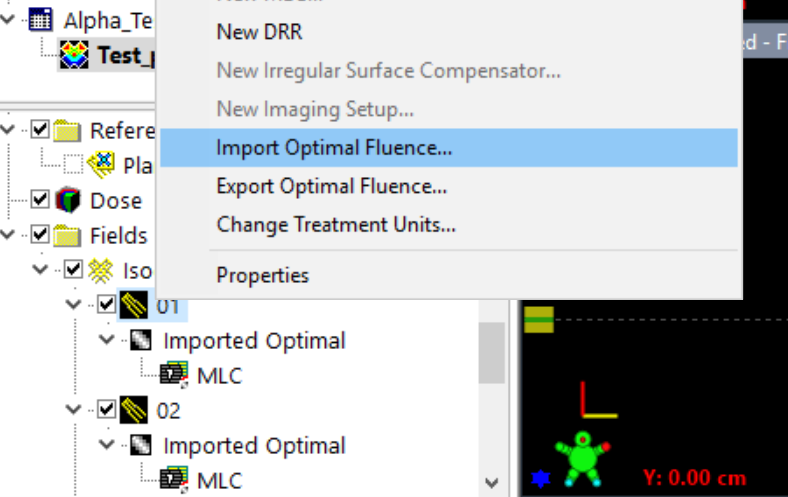

#### 2.b) Run dose calculation in eclipse and normalize the plan properly.
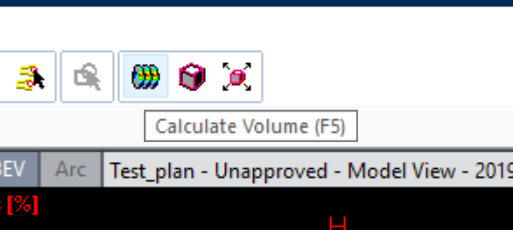

### 3) Export RT DICOM dose from eclipse and convert it into portpy format
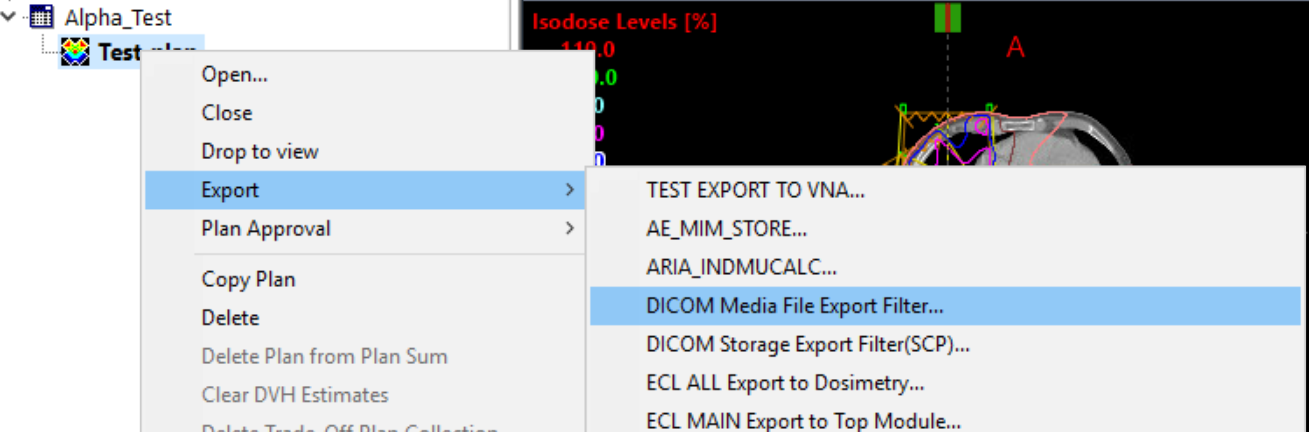

In [6]:
# Export dose in dicom format from eclipse and specify it below
dose_file_name = os.path.join(r'C:\temp', data.patient_id, 'rt_dose.dcm')  # Use need to modify the file name accordingly
ecl_dose_3d = pp.convert_dose_rt_dicom_to_portpy(my_plan=my_plan, dose_file_name=dose_file_name)
ecl_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=ecl_dose_3d)

### 4)  Visualize the dose discrepancy between optimization (with full influence matrix) and Eclipse dose

In [7]:
# load full influence matrix to calculate dose using full matrix
beams_full = pp.Beams(data, load_inf_matrix_full=True)
# load influence matrix based upon beams and structure set
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
dose_full_1d = inf_matrix_full.A @ (sol['optimal_intensity'] * my_plan.get_num_of_fractions()) # calculate dose using full matrix

Creating BEV..
Loading full influence matrix..
Done


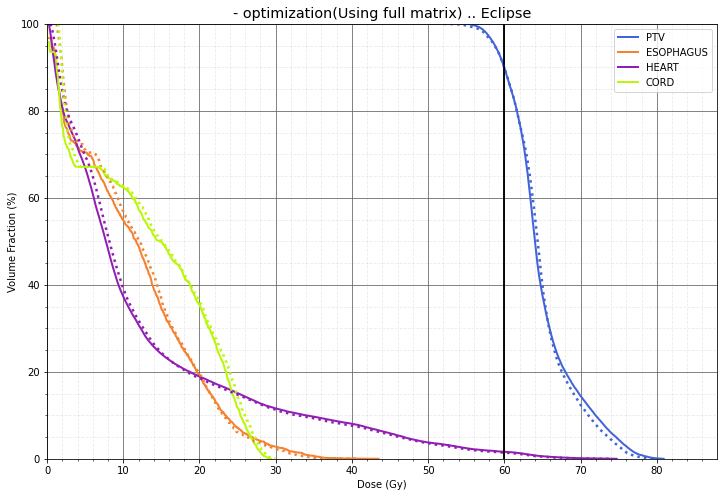

Done!


In [8]:
# Visualize the DVH discrepancy between eclipse dose and dose using full matrix in portpy
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_full_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- optimization(Using full matrix) .. Eclipse')
plt.show()
print('Done!')

### 5)  Visualize the dose discrepancy using full and sparse influence matrix

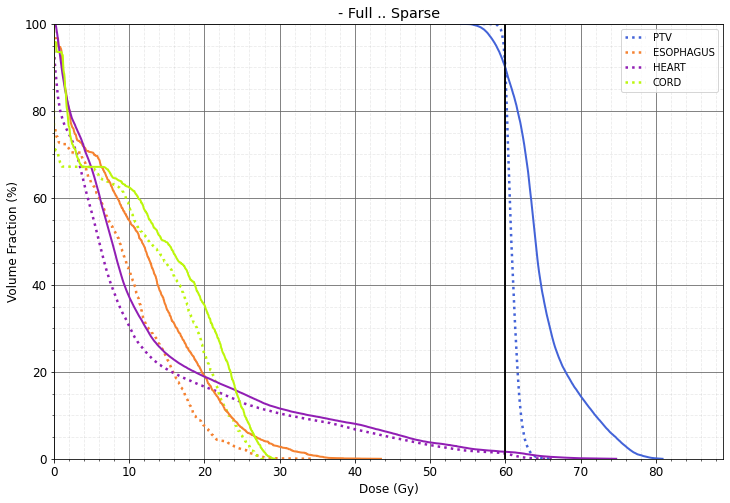

Done!


In [9]:
# Visualize the DVH discrepancy between sparse and full
dose_sparse_1d = inf_matrix.A @ (sol['optimal_intensity'] * my_plan.get_num_of_fractions())
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_sparse_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_full_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax.set_title('- Full .. Sparse')
plt.show()
print('Done!')

### 6)  Dose Correction optimization and visualization

In this step, we correct the dose in the optimization so that final dose using full influence matrix is similar to the dose using sparse influence matrix.

Optimization problem using the sparse influence matrix (S) is of the form,

$ 
\mathbf{x^*} = argmin f(S\mathbf{x}) + g(\mathbf{x})\\
h(S\mathbf{x}) \leq 0
$

We can estimate the discrepancy between full and sparse dose using the above optimal solution which is given by,
$ 
\delta = A\mathbf{x^*}-S\mathbf{x^*}
$
 
We then perform dose correction optimization in order to minimize the dose discrepancy between full and sparse dose.

$
\mbox{Minimize}: f(S\mathbf{x^*} + \delta)+g(\mathbf{x^*})\\
\mbox{s.t}
\quad \quad h(S\mathbf{x^{*}} + \delta) \leq 0
$

In [10]:
# calculating delta
# normalize both the dose to PTV:V(100%) = 90%
norm_volume = 90
norm_struct = 'PTV'
pres = my_plan.get_prescription()

norm_factor_sparse = pp.Evaluation.get_dose(sol, dose_1d=dose_sparse_1d, struct=norm_struct, volume_per=norm_volume) / pres
dose_sparse_1d_norm = dose_sparse_1d / norm_factor_sparse

norm_factor_full = pp.Evaluation.get_dose(sol, dose_1d=dose_full_1d, struct=norm_struct, volume_per=norm_volume) / pres
dose_full_1d_norm = dose_full_1d / norm_factor_full

delta = (dose_full_1d_norm - dose_sparse_1d_norm)/my_plan.get_num_of_fractions()

Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 60.36822621618386
Elapsed time: 235.7137246131897 seconds


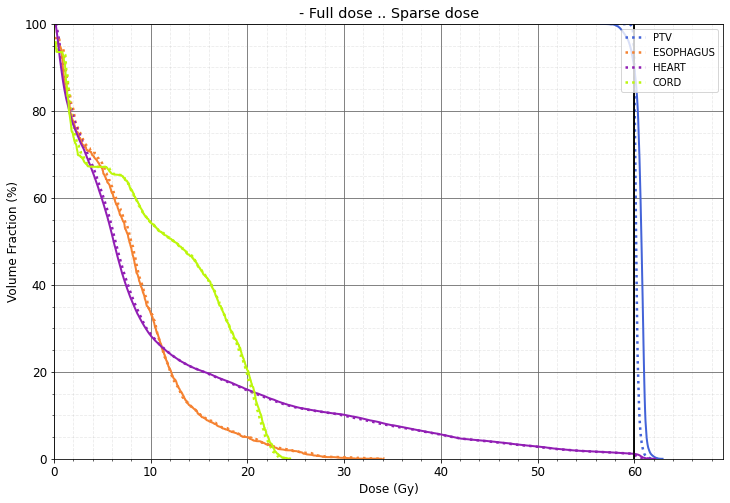

Done!
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 59.61992138988597
Elapsed time: 244.5445203781128 seconds


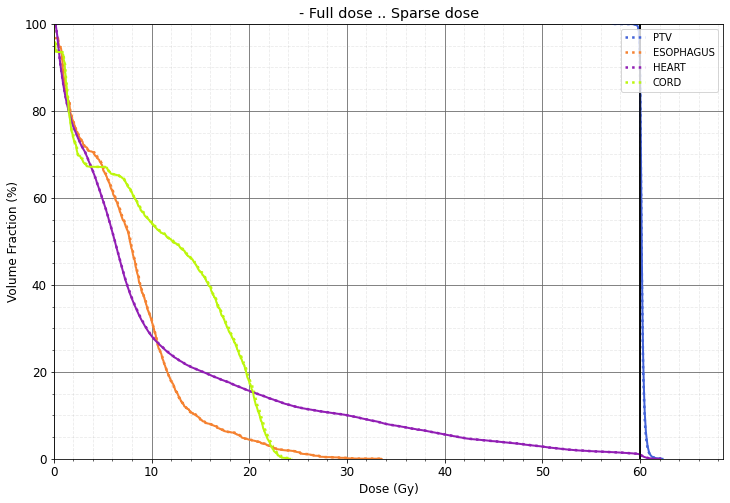

Done!


In [11]:
# Building up the correction model. It is the same opitmization problem but with corrected dose
# get opt params for optimization
old_delta = delta
num_corr = 2
for i in range(num_corr):

    A = inf_matrix.A
    opt = pp.Optimization(my_plan, opt_params=opt_params)
    opt.create_cvxpy_problem_correction(delta=delta) # input delta
    sol_corr = opt.solve(solver='MOSEK', verbose=False)
    
    dose_sparse_corr_1d = (inf_matrix.A @ sol_corr['optimal_intensity'] + delta) * my_plan.get_num_of_fractions()
    dose_full_corr_1d = inf_matrix_full.A @ (sol_corr['optimal_intensity'] * my_plan.get_num_of_fractions())
    
    # recalculate delta
    norm_volume = 90
    norm_struct = 'PTV'
    pres = my_plan.get_prescription()

    norm_factor_sparse = pp.Evaluation.get_dose(sol, dose_1d=dose_sparse_corr_1d, struct=norm_struct, volume_per=norm_volume) / pres
    dose_sparse_corr_1d_norm = dose_sparse_corr_1d / norm_factor_sparse

    norm_factor_full = pp.Evaluation.get_dose(sol, dose_1d=dose_full_corr_1d, struct=norm_struct, volume_per=norm_volume) / pres
    dose_full_corr_1d_norm = dose_full_corr_1d / norm_factor_full

    delta = (dose_full_corr_1d_norm - dose_sparse_corr_1d_norm)/my_plan.get_num_of_fractions()
    
    # Visualize DVH in correction step
    struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_sparse_corr_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
    # ax = pp.Visualization.plot_dvh(my_plan, sol=sol_corr, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
    ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_full_corr_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
    ax.set_title('- Full dose .. Sparse dose')
    plt.show()
    print('Done!')
    delta = old_delta + delta
    old_delta = delta

It can ben seen using above dvh plot that the discrepancy between sparse and full dose calculation has been reduced after 2 correction optimization loop. Users can modify 'num_corr' to modify the number of correction loop to get optimized dose similar to eclipse dose

<Axes: title={'center': 'Axial View - Slice #: 40'}>

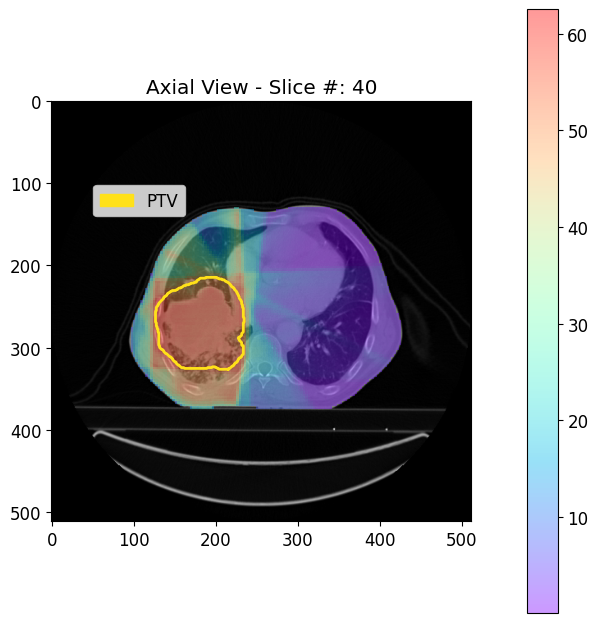

In [12]:
# plot 2d axial slice for the given solution and display the structures contours on the slice
pp.Visualization.plot_2d_slice(my_plan=my_plan, sol=sol_corr, slice_num=40, struct_names=['PTV'])

In [17]:
# Repeat anove steps of importing fluence to eclipse, perform final dose calculation import the dose back to portpy
# save fluence using correction optimization
pp.get_eclipse_fluence(my_plan=my_plan, sol=sol_corr, path=os.path.join(r'C:\temp', data.patient_id))

In [18]:
# Export corrected dose in dicom format from eclipse and specify it below
dose_file_name = os.path.join(r'C:\temp', data.patient_id, 'rt_dose_corr.dcm')  # Use need to modify the file name accordingly
ecl_dose_3d_corr = pp.convert_dose_rt_dicom_to_portpy(my_plan=my_plan, dose_file_name=dose_file_name)
ecl_dose_1d_corr = inf_matrix.dose_3d_to_1d(dose_3d=ecl_dose_3d_corr)

In [20]:
# import benchmark plan from the patient directory (planner's plan)
# import planner's dose into portpy
planner_dose_3d = pp.convert_dose_rt_dicom_to_portpy(ct=ct,
                                                         dose_file_name=os.path.join(data_dir, data.patient_id, 'rt_dose.dcm'))
planner_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=planner_dose_3d)

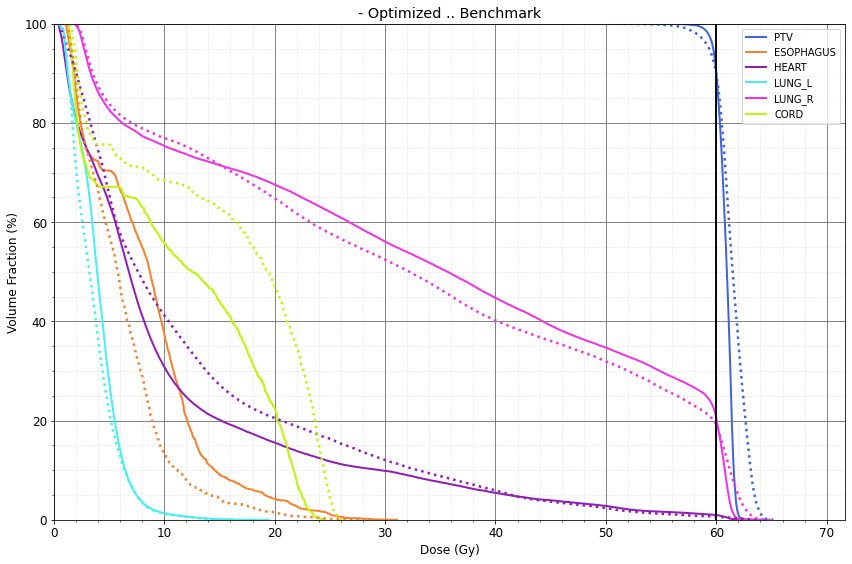

Done!


In [22]:
# compare dvh of our optimized plan with final dose calculation with benchmark plan (planner's plan)
# Visualize the DVH discrepancy between eclipse dose and dose using full matrix in portpy
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNG_L','LUNG_R']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d_corr, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=planner_dose_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- Optimized .. Benchmark')
plt.show()
print('Done!')